In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from numpy import array
from tensorflow.keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D
from tensorflow.keras.models import load_model
word_tokenizer = text.Tokenizer()

In [2]:
import pandas as pd
try:
    movie_reviews = pd.read_csv('/content/IMDB Dataset.csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    problematic_row_index = 35632
    with open('/content/IMDB Dataset.csv', 'r') as file:
        lines = file.readlines()
        for i in range(problematic_row_index - 2, problematic_row_index + 3):
            if 0 <= i < len(lines):
                print(f"Line {i+1}: {lines[i]}")

In [3]:
movie_reviews.isnull().any()

,0
review,False
sentiment,False


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
target_tag = re.compile(r'<[^>]+>')

def remove_tags(text):
    return target_tag.sub('', text)
def preprocess_text(sen):
    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence

In [6]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [7]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [9]:
word_tokenizer = text.Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [10]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

94680

In [11]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
!kaggle datasets download -d sawarn69/glove6b100dtxt

Dataset URL: https://www.kaggle.com/datasets/sawarn69/glove6b100dtxt
License(s): unknown
100% 131M/131M [00:06<00:00, 21.9MB/s]
100% 131M/131M [00:06<00:00, 20.5MB/s]


In [13]:
!unzip glove6b100dtxt.zip

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [14]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
embedding_matrix.shape

(94680, 100)

In [17]:
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [19]:
history = model.fit(X_train, y_train, batch_size=64, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - acc: 0.6880 - loss: 0.5800 - val_acc: 0.8060 - val_loss: 0.4444
Epoch 2/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.8098 - loss: 0.4277 - val_acc: 0.8120 - val_loss: 0.4042
Epoch 3/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.8358 - loss: 0.3772 - val_acc: 0.8414 - val_loss: 0.3595
Epoch 4/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.8537 - loss: 0.3405 - val_acc: 0.8568 - val_loss: 0.3433
Epoch 5/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.8685 - loss: 0.3150 - val_acc: 0.8631 - val_loss: 0.3193
Epoch 6/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.8811 - loss: 0.2895 - val_acc: 0.8675 - val_loss: 0.3108


In [20]:
model.evaluate(X_test, y_test, verbose=1)

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8711 - loss: 0.3073


[0.31031888723373413, 0.8693333268165588]

In [21]:
import matplotlib.pyplot as plt

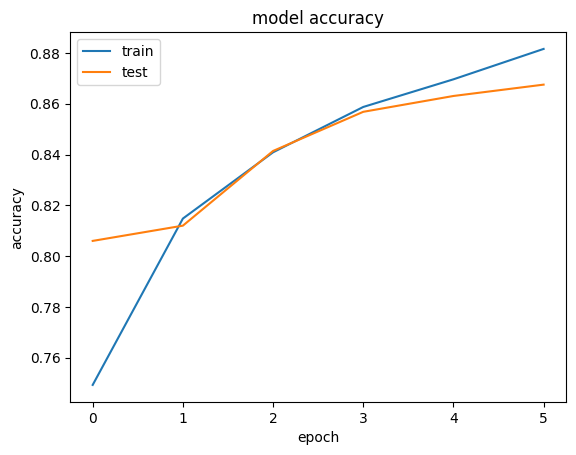

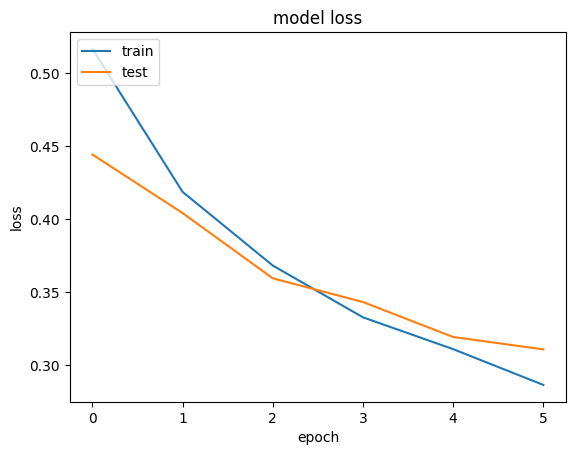

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [32]:
review = 'Im not going to give a long winded review though the movie was long. "Eternal" was the runtime. There were parts that were good and parts that weren\'t. One of the biggest issues is that a movie of this nature presents more questions than it answers. The very existence of eternal beings existing on planet Earth, sent there by their creator in order to protect human life from Deviants, begs a lot of questions. And the more they strayed from their prime directive, the more questions they presented. The eternals were human in every aspect with the exception of their powers and their lifespan. The fact that such humanlike and very fallible beings (as in not entirely obedient) were sent to protect humans is just a start of the questions'

In [33]:
review = preprocess_text(review)

In [34]:
maxlen = 100

In [35]:
tokenized_text = word_tokenizer.texts_to_sequences(review)
padded_text = pad_sequences(tokenized_text, padding='post', maxlen=maxlen)

In [36]:
y_pred = model.predict(padded_text)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [37]:
maxi = -1
for i in range(len(y_pred[0])):
  if y_pred[0][i] > maxi:
    maxi = y_pred[0][i]

In [39]:
maxi

0.44040623

In [38]:
np.round(np.mean(y_pred)*10,1)

5.0

In [40]:
model.save('/content/lstm_movie_review_model.keras')